In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

sys.path.append("../")
from evraz.settings import Connection

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("../../data/raw/")

In [3]:
conn = Connection().open_conn().ping()

## Сбор фичей

In [9]:
target = pd.read_csv("../../data/raw/target_train.csv")
target

,NPLV,TST,C
0,510008,1690,0.060
1,510009,1683,0.097
2,510010,1662,0.091
3,510011,1609,0.410
4,510012,1682,0.120
...,...,...,...
2058,512318,1626,0.145
2059,512319,1643,0.087
2060,512320,1615,0.141
2061,512321,1654,0.270


<AxesSubplot:ylabel='Frequency'>

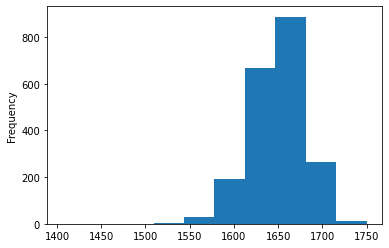

In [15]:
target.TST.plot.hist()

### Простые фичи

In [73]:
df = conn.read_query(f"""
select * from target_train target
left join plavki_train plavki using("NPLV")
left join chugun_train chugun using("NPLV")
""")
df = df.dropna(subset=['TST', 'C'])
df

,NPLV,TST,C,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,...,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008.0,1690.0,0.060,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971.0,цилиндрическая,11.0,...,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009.0,1683.0,0.097,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972.0,цилиндрическая,12.0,...,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010.0,1662.0,0.091,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973.0,цилиндрическая,13.0,...,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40
3,510011.0,1609.0,0.410,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974.0,цилиндрическая,14.0,...,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,2021-01-01 06:20:57
4,510012.0,1682.0,0.120,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975.0,цилиндрическая,15.0,...,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,2021-01-01 07:23:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,512318.0,1626.0,0.145,2021-04-26 13:04:26,2021-04-26 13:55:50,C071TM.z01/ЭТ,МНЛС,3281.0,коническая,22.0,...,0.38,0.28,0.019,0.099,0.02,0.01,0.02,0.081,0.060,2021-04-26 12:53:40
2133,512319.0,1643.0,0.087,2021-04-26 14:10:20,2021-04-26 15:14:23,C071TM.z01/ЭТ,МНЛС,3282.0,коническая,23.0,...,0.50,0.30,0.017,0.104,0.02,0.01,0.02,0.079,0.081,2021-04-26 14:21:57
2134,512320.0,1615.0,0.141,2021-04-26 15:21:37,2021-04-26 16:16:42,40Х.1,МНЛЗ,3283.0,коническая,24.0,...,0.61,0.31,0.025,0.115,0.03,0.01,0.03,0.086,0.066,2021-04-26 14:33:29
2135,512321.0,1654.0,0.270,2021-04-26 16:22:37,2021-04-26 17:23:37,40Х.1,МНЛЗ,3284.0,коническая,25.0,...,0.38,0.27,0.021,0.100,0.02,0.01,0.03,0.076,0.060,2021-04-26 15:50:53


In [74]:
id_column = 'NPLV'
target_columns = ['TST', 'C']
time_columns = df.columns[df.dtypes == 'datetime64[ns]'].difference(target_columns + [id_column]).tolist()
float_columns = df.columns[df.dtypes == 'float64'].difference(target_columns + [id_column]).tolist()
obj_columns = df.columns[df.dtypes == 'object'].difference(target_columns + [id_column]).tolist()

#### Категориальные признаки

In [75]:
df = df.astype({n: pd.CategoricalDtype() for n in obj_columns})
df[obj_columns].describe()

,plavka_NAPR_ZAD,plavka_NMZ,plavka_TIPE_FUR,plavka_TIPE_GOL
count,2135,2135,2135,2135
unique,3,66,2,4
top,МНЛС,Ст3пс/Э,цилиндрическая,5 сопловая
freq,942,304,1997,1523


#### Числовые признаки

In [76]:
df[float_columns].describe()

,CR,CU,MN,NI,P,S,SI,T,TI,V,VES,plavka_STFUT,plavka_ST_FURM,plavka_ST_GOL
count,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000,2135.000000
mean,0.018904,0.021199,0.253752,0.009077,0.082828,0.014816,0.484974,1397.523653,0.074318,0.071156,266616.252927,2124.053396,74.881499,87.335363
std,0.007673,0.009269,0.090842,0.003260,0.028664,0.006862,0.204341,57.921167,0.033183,0.026907,12017.518570,653.625899,74.445702,76.166375
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,971.000000,1.000000,1.000000
25%,0.020000,0.020000,0.240000,0.010000,0.080000,0.012000,0.400000,1385.500000,0.059000,0.065000,264600.000000,1567.500000,19.000000,24.000000
50%,0.020000,0.020000,0.270000,0.010000,0.090000,0.015000,0.510000,1403.000000,0.079000,0.077000,266100.000000,2098.000000,47.000000,60.000000
75%,0.020000,0.030000,0.300000,0.010000,0.098000,0.019000,0.620000,1416.000000,0.095500,0.087000,269600.000000,2673.500000,108.000000,141.000000
max,0.050000,0.060000,0.460000,0.020000,0.141000,0.063000,0.960000,1470.000000,0.240000,0.161000,312700.000000,3285.000000,336.000000,336.000000


## Model

In [78]:
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor
from evraz.metrics import metric


class UnitedModel(RegressorMixin, BaseEstimator):
    def __init__(self, 
                 model_params: dict):
        self.model_params = model_params
        self.model_params.update({
            'random_state': 42,
            'eval_metric': 'MAE',
            'early_stopping_rounds': 10,
            'iterations': 1000
        })
        self.model_t = CatBoostRegressor(**self.model_params)
        self.model_c = CatBoostRegressor(**self.model_params)
        
    def fit(self, X, y, eval_set=None, **kwargs):
        self.model_t.fit(X, y['TST'], eval_set=eval_set, **kwargs)
        self.model_c.fit(X, y['C'], eval_set=eval_set, **kwargs)
        return self
    
    def predict(self, X):
        t_preds = self.model_t.predict(X)
        c_preds = self.model_c.predict(X)
        return pd.DataFrame.from_dict({
            'TST': t_preds,
            'C': c_preds
        })
    
    def eval_metric(X, y):
        y_pred = self.predict(X)
        metrics = {
            'business': metric(y, y_pred)
        }
        


model = UnitedModel({
    'depth': 5,
    'cat_features': obj_columns
}).fit(
    df.dropna(subset=['TST', 'C'])[float_columns + obj_columns], 
    df[target_columns],
    silent=True
)

In [80]:
metric(df[target_columns], model.predict(df[float_columns + obj_columns]))

0.6789227166276347